In [83]:
import numpy as np
import pingouin as pg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import correlation
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay, make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, ShuffleSplit
import xarray as xr

In [84]:
import warnings
warnings.filterwarnings('ignore')

In [85]:
def custom_corr(y, y_pred):
    corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
    return corr

In [124]:
corr_scorer = make_scorer(custom_corr)
mape_scorer = make_scorer(mean_absolute_percentage_error)

In [125]:
target = 'PicVocab_AgeAdj'
target_pred = f'{target}_pred'
dataset_name = "data/hcp_kong_400parcels.nc"

In [173]:
exp_name = '1run_train_redmat_enc_hcp_sup_net_latest'
root = '.'
exp_dir = f"{root}/results/{exp_name}"

In [174]:
predictions = pd.read_csv(f'{exp_dir}/pred_results.csv')
sub_idx_train = predictions[(predictions["dataset"] == 'train') & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)].indices.values
sub_idx_test = predictions[(predictions["dataset"] == 'test') & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)].indices.values

In [175]:
exp_dir

'./results/1run_train_redmat_enc_hcp_sup_net_latest'

In [176]:
embedding_dir = f"{exp_dir}/embeddings"
X_train = np.load(f"{embedding_dir}/joint_embeddings_run0_train.npy")
y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)][target].values
y_train_deep_pred = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)][target_pred].values

X_test = np.load(f"{embedding_dir}/joint_embeddings_run0_test.npy")
y_test = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)][target].values
y_test_deep_pred = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)][target_pred].values

In [177]:
ridge_estimator = Ridge(alpha=1)
fitted_ridge = ridge_estimator.fit(X_train, y_train)
y_train_pred = fitted_ridge.predict(X_train)
y_test_pred = fitted_ridge.predict(X_test)

In [178]:
np.save(f"{exp_dir}/ridge_y_pred_train.npy", y_train_pred)
np.save(f"{exp_dir}/ridge_y_pred_test.npy", y_test_pred)

In [179]:
fitted_ridge.score(X_train, y_train)

0.8392750640344462

In [180]:
custom_corr(y_test, y_test_pred)

0.4620280345078838

In [181]:
custom_corr(y_train, y_train_pred)

0.9182576243102324

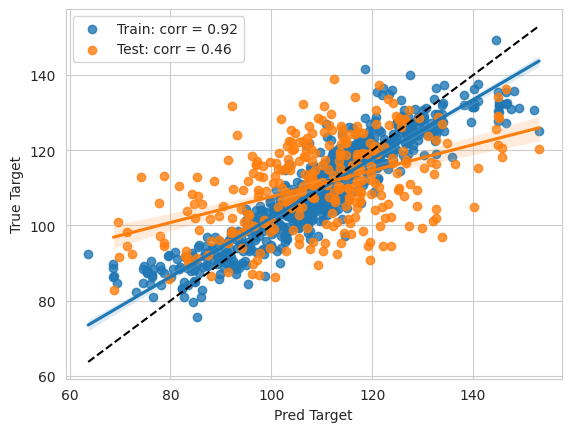

In [199]:
train_corr = custom_corr(y_train, y_train_pred)
test_corr = custom_corr(y_test, y_test_pred)

sns.regplot(x=y_train, y=y_train_pred, label=f"Train: corr = {train_corr:.2f}")
sns.regplot(x=y_test, y=y_test_pred, label=f"Test: corr = {test_corr:.2f}")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], linestyle='--', c='black')
plt.ylabel("True Target")
plt.xlabel("Pred Target")
plt.legend()
plt.show()

Text(0.5, 0, '')

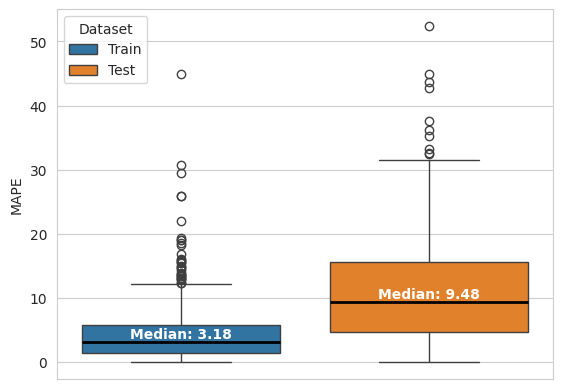

In [219]:
mape_df = pd.DataFrame({
    "sub_id": np.concat([sub_idx_train, sub_idx_test]),
    "dataset": ["Train"]*len(sub_idx_train) + ["Test"]*len(sub_idx_test),
    "MAPE": np.concat([100*np.abs(y_train-y_train_pred)/y_train, 100*np.abs(y_test-y_test_pred)/y_test])
})
median_mape_train = np.median(100*np.abs(y_train-y_train_pred)/y_train)
median_mape_test = np.median(100*np.abs(y_test-y_test_pred)/y_test)

sns.set_style("whitegrid")
sns.boxplot(data=mape_df, x='dataset', y='MAPE', hue='dataset',
            legend=True,
            medianprops={"color": "black", "linewidth": 2}
              )
plt.text(0, median_mape_train + 0.5, f'Median: {median_mape_train:.2f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
plt.text(1, median_mape_test+ 0.5, f'Median: {median_mape_test:.2f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
plt.xticks([], [])
# plt.ylim(-.05, 1.05)
plt.legend(title='Dataset', loc='upper left')
plt.xlabel('Value')
plt.xlabel('')


Text(0.5, 1.0, 'MAPE Test')

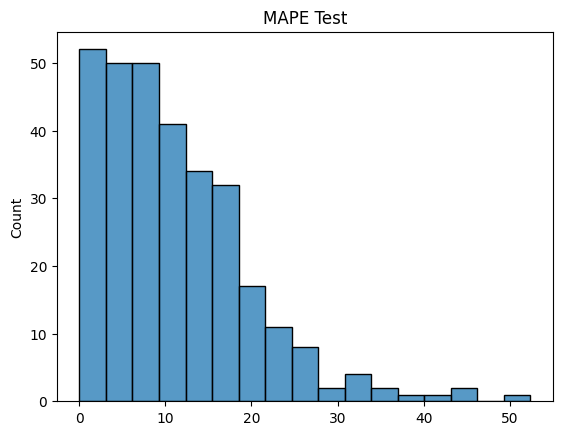

In [184]:
sns.histplot(x=100*np.abs(y_test-y_test_pred)/y_test)
plt.title("MAPE Test")

<Axes: xlabel='Mean of x and y', ylabel='x - y'>

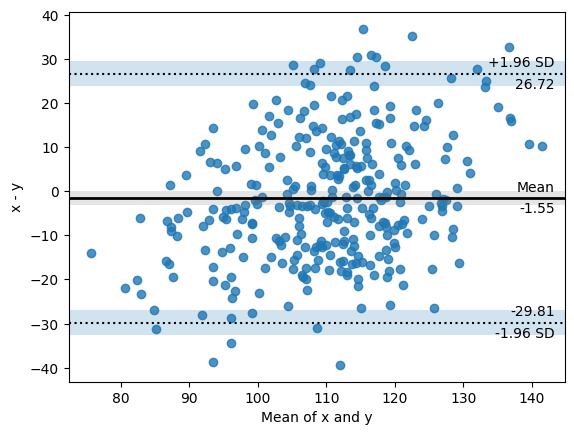

In [185]:
pg.plot_blandaltman(y_test, y_test_pred)